<a href="https://colab.research.google.com/github/VaishnaviDayal7/Uber/blob/main/Uber_RCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Problem Statement**

Uber experiences significant supply-demand imbalances, particularly in airport and city rides at specific times of the day.

# **Objective**

To perform RCA and mitigate the supply-demand gaps in Uber’s ride requests

In [ ]:
#importing all the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!gdown 1ZhqCqM5xtMNsun-xBhfvtrYH2RlM1Ue5

Downloading...
From: https://drive.google.com/uc?id=1ZhqCqM5xtMNsun-xBhfvtrYH2RlM1Ue5
To: /content/uber-data.csv
100% 395k/395k [00:00<00:00, 46.6MB/s]


In [ ]:
df = pd.read_csv('uber-data.csv',dayfirst = True, na_values = 'NaN')
df.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


In [ ]:
df.shape

(6745, 6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Request id         6745 non-null   int64  
 1   Pickup point       6745 non-null   object 
 2   Driver id          4095 non-null   float64
 3   Status             6745 non-null   object 
 4   Request timestamp  6745 non-null   object 
 5   Drop timestamp     2831 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 316.3+ KB


Observations:

1. The dataset consists of 6,745 ride requests, with complete records

2. There are significant missing values in the Driver ID (40% missing) where no drivers were assigned, likely due to high demand or unavailability

3. The drop timings are missing (58% missing) which indicate canceled rides

# Date Formatting

In [ ]:
df['Request timestamp_1'] = pd.to_datetime(df['Request timestamp'], format='%d-%m-%Y %H:%M:%S', errors='coerce')
df['Request timestamp_2']=pd.to_datetime(df['Request timestamp'], format='%d/%m/%Y %H:%M', errors='coerce')
df['Request timestamp']=df['Request timestamp_2'].combine_first(df['Request timestamp_1'])
df['Drop timestamp_1'] = pd.to_datetime(df['Drop timestamp'], format='%d-%m-%Y %H:%M:%S', errors='coerce')
df['Drop timestamp_2']=pd.to_datetime(df['Drop timestamp'], format='%d/%m/%Y %H:%M', errors='coerce')
df['Drop timestamp']=df['Drop timestamp_2'].combine_first(df['Drop timestamp_1'])
df.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,Request timestamp_1,Request timestamp_2,Drop timestamp_1,Drop timestamp_2
0,619,Airport,1.0,Trip Completed,2016-07-11 11:51:00,2016-07-11 13:00:00,NaT,2016-07-11 11:51:00,NaT,2016-07-11 13:00:00
1,867,Airport,1.0,Trip Completed,2016-07-11 17:57:00,2016-07-11 18:47:00,NaT,2016-07-11 17:57:00,NaT,2016-07-11 18:47:00
2,1807,City,1.0,Trip Completed,2016-07-12 09:17:00,2016-07-12 09:58:00,NaT,2016-07-12 09:17:00,NaT,2016-07-12 09:58:00
3,2532,Airport,1.0,Trip Completed,2016-07-12 21:08:00,2016-07-12 22:03:00,NaT,2016-07-12 21:08:00,NaT,2016-07-12 22:03:00
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,2016-07-13 08:33:16,NaT,2016-07-13 09:25:47,NaT


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.isnull().sum()/len(df) *100

,0
Request id,0.000000
Pickup point,0.000000
Driver id,39.288362
Status,0.000000
Request timestamp,0.000000
Drop timestamp,58.028169


In [ ]:
df['RequestHour'] = df['Request timestamp'].dt.hour
df.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,RequestHour
0,619,Airport,1.0,Trip Completed,2016-07-11 11:51:00,2016-07-11 13:00:00,11
1,867,Airport,1.0,Trip Completed,2016-07-11 17:57:00,2016-07-11 18:47:00,17
2,1807,City,1.0,Trip Completed,2016-07-12 09:17:00,2016-07-12 09:58:00,9
3,2532,Airport,1.0,Trip Completed,2016-07-12 21:08:00,2016-07-12 22:03:00,21
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,8


In [ ]:
# We will bin the time slots
df["TimeSlot"] = df["RequestHour"].apply(lambda x: "Dawn" if x<=4 else ("Early Morning"
                                                                        if x<=9 else ("Noon"
                                                                                      if x<=16 else ("Late Evening"
                                                                                                     if x<=21 else "Night"))))

df.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,RequestHour,TimeSlot
0,619,Airport,1.0,Trip Completed,2016-07-11 11:51:00,2016-07-11 13:00:00,11,Noon
1,867,Airport,1.0,Trip Completed,2016-07-11 17:57:00,2016-07-11 18:47:00,17,Late Evening
2,1807,City,1.0,Trip Completed,2016-07-12 09:17:00,2016-07-12 09:58:00,9,Early Morning
3,2532,Airport,1.0,Trip Completed,2016-07-12 21:08:00,2016-07-12 22:03:00,21,Late Evening
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,8,Early Morning


In [ ]:
df.TimeSlot.value_counts()

,count
TimeSlot,
Late Evening,2342
Early Morning,2103
Noon,1224
Dawn,578
Night,498


In [ ]:
df['Status'].value_counts()

,count
Status,
Trip Completed,2831
No Cars Available,2650
Cancelled,1264


In [ ]:
df["Cab Availability"] = df["Status"].apply(lambda x: "Available" if x=="Trip Completed" else "Not Available")
df['Cab Availability'].value_counts()

,count
Cab Availability,
Not Available,3914
Available,2831


In [ ]:
df.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,RequestHour,TimeSlot,Cab Availability
0,619,Airport,1.0,Trip Completed,2016-07-11 11:51:00,2016-07-11 13:00:00,11,Noon,Available
1,867,Airport,1.0,Trip Completed,2016-07-11 17:57:00,2016-07-11 18:47:00,17,Late Evening,Available
2,1807,City,1.0,Trip Completed,2016-07-12 09:17:00,2016-07-12 09:58:00,9,Early Morning,Available
3,2532,Airport,1.0,Trip Completed,2016-07-12 21:08:00,2016-07-12 22:03:00,21,Late Evening,Available
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,8,Early Morning,Available


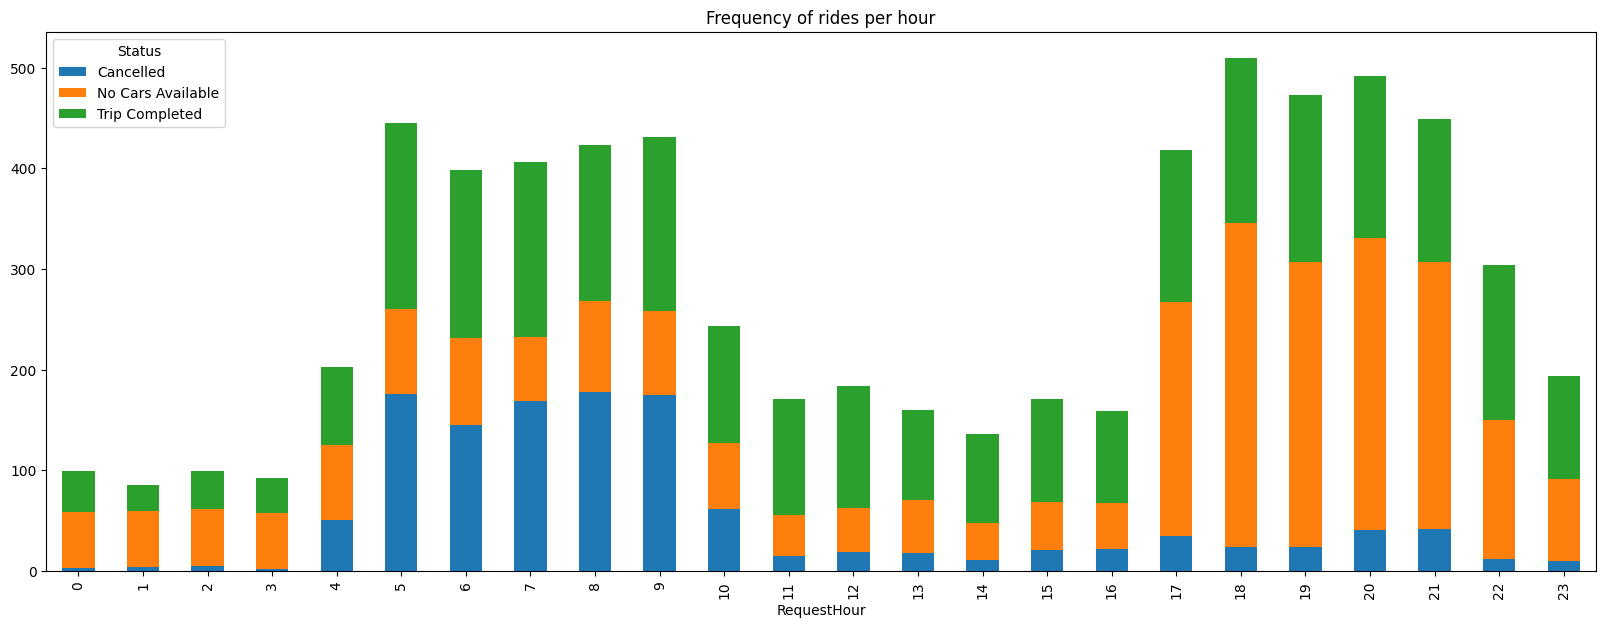

In [ ]:
df.groupby(['RequestHour','Status']).size().unstack().plot(kind='bar',stacked='True',figsize=(20,7))
plt.title('Frequency of rides per hour')
plt.show()

# **Observations based on hours:**

1-3 : Issue of less supply, very less demand

5-9 :  supply is there but More cancelled rides, and demand is increasing steadily

10 - 16 : there is less demand

17 - 22 : the demand is high but suppy is very very less


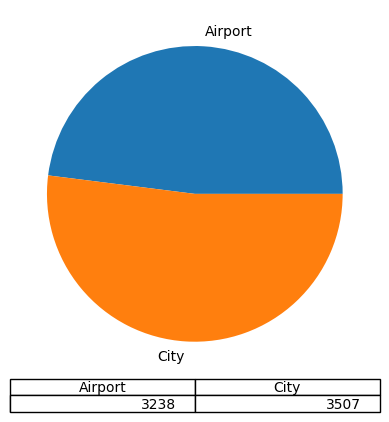

In [ ]:
df.groupby(['Pickup point']).size().plot(kind='pie', table=True, stacked='True')
plt.show()

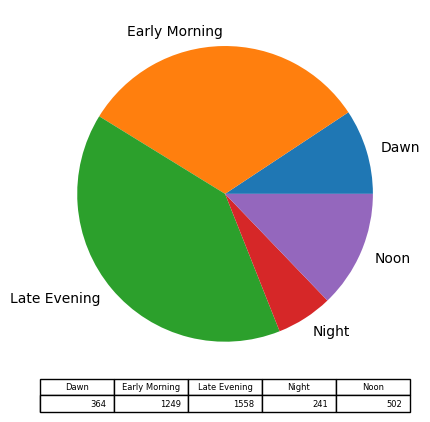

In [ ]:
df[df['Cab Availability']== "Not Available"].groupby(['TimeSlot']).size().plot(kind ='pie', stacked = True, table = True)
plt.show()

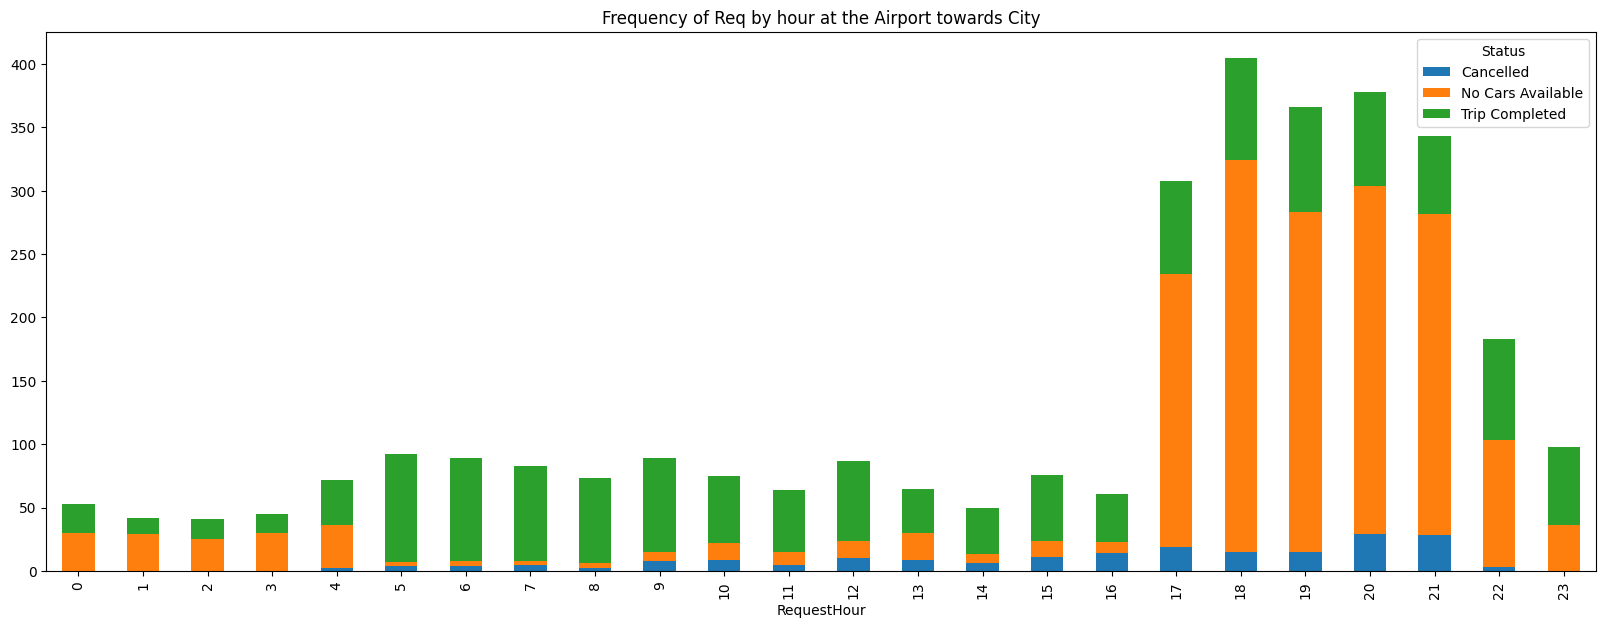

In [ ]:
df[df['Pickup point']== 'Airport'].groupby(['RequestHour', 'Status']).size().unstack().plot(kind ='bar', stacked = True,figsize =(20,7))
plt.title("Frequency of Req by hour at the Airport towards City")
plt.show()

Observation: Till 4pm, there are no or less cancellations. There are issues of cancellations, but there is supply and no demand

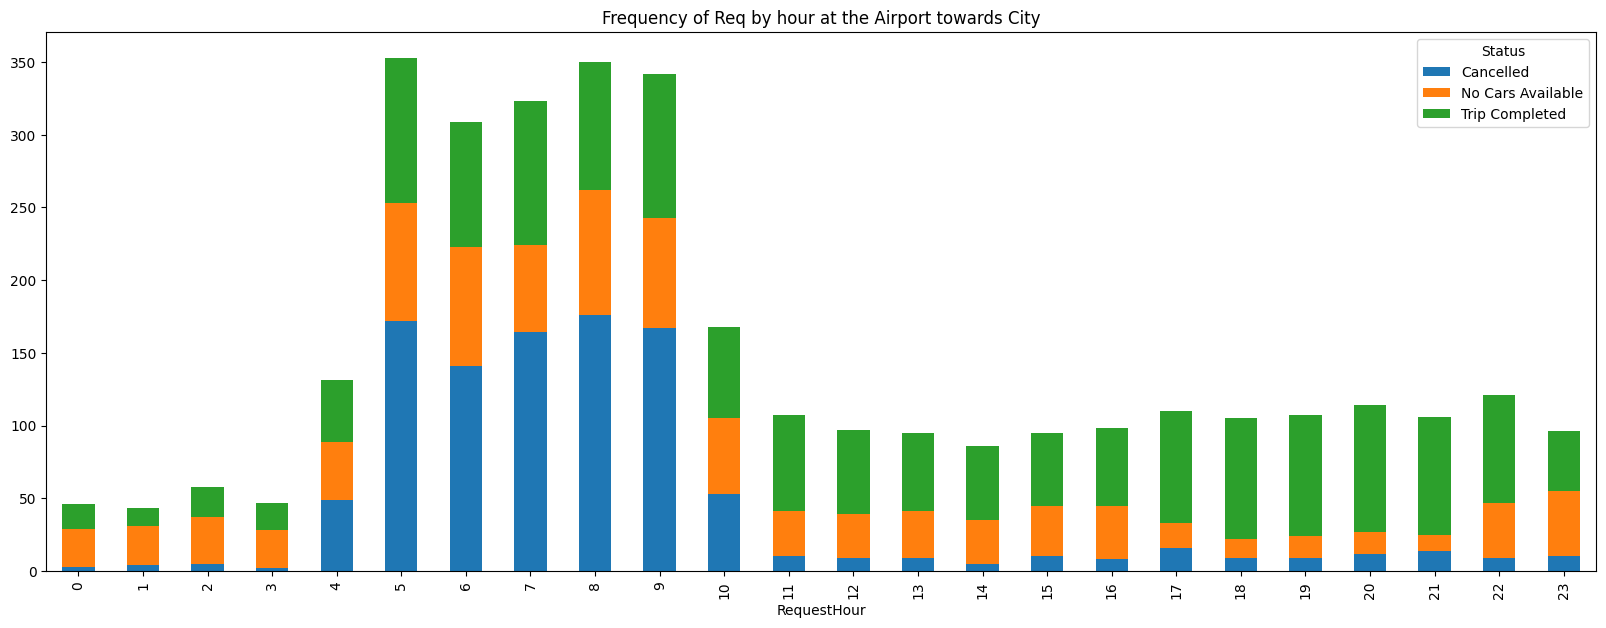

In [ ]:
df[df['Pickup point']== 'City'].groupby(['RequestHour', 'Status']).size().unstack().plot(kind ='bar', stacked = True,figsize =(20,7))
plt.title("Frequency of Req by hour at the City towards Airport")
plt.show()

Observation: There is very less demand in the morning from airport to city hence there is high cancellation

# **Insights:**

# 1. Supply & Demand:

**Late Evening (17:00 - 22:00)**: There is high demand, but supply is very low, leading to many unfulfilled requests.

**Early Morning (5:00 - 9:00)**: Supply exists, but cancellations are frequent, likely due to changing rider needs or pricing concerns.

**Midday (10:00 - 16:00)**: Demand is relatively low, meaning fewer trips occur.
Late Night/Dawn (1:00 - 3:00): Both supply and demand are low.

# 2. Airport vs. City Ride Patterns

**Airport to City:** High cancellation rates in the morning indicate either a mismatch in availability or pricing concerns.

**City to Airport:** Demand peaks in the evening but lacks enough supply to meet it.

**Recommendations:**

- Incentive for waiting time for drivers on airports

- Extend search radius for drivers so that they can fulfil the nearby drop offs

- Onboard more drivers during evening to meet the surging demand

- Carpooling towards airport for better revenue to drivers


In [ ]:
for i in range(50):
  print("'print'")

'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
'print'
